# Create Synthetic Dataset

Here, we create a synthetic dataset of images with 3 underlying factor of variations : the amplitude of noise, the angle of strips and their frequency.

![title](synthetic_space.PNG)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
from tqdm import tqdm
% matplotlib inline

### Implementation

In [7]:
"""
Texture generation using Perlin noise
"""
class NoiseUtils:
    
    def __init__(self, imageSize, angle, frequency, amplitude):
        self.imageSize = imageSize
        self.angle = angle
        self.frequency= frequency
        self.amplitude = amplitude
        self.gradientNumber = 256

        self.grid = [[]]
        self.gradients = []
        self.permutations = []
        self.img = np.zeros(shape=(self.imageSize, self.imageSize))

        self.__generateGradientVectors()
        self.__normalizeGradientVectors()
        self.__generatePermutationsTable()

    def __generateGradientVectors(self):
        for i in range(self.gradientNumber):
            while True:
                x, y = random.uniform(-1, 1), random.uniform(-1, 1)
                if x * x + y * y < 1:
                    self.gradients.append([x, y])
                    break

    def __normalizeGradientVectors(self):
        for i in range(self.gradientNumber):
            x, y = self.gradients[i][0], self.gradients[i][1]
            length = math.sqrt(x * x + y * y)
            self.gradients[i] = [x / length, y / length]

    # The modern version of the Fisher-Yates shuffle
    def __generatePermutationsTable(self):
        self.permutations = [i for i in range(self.gradientNumber)]
        for i in reversed(range(self.gradientNumber)):
            j = random.randint(0, i)
            self.permutations[i], self.permutations[j] = \
                self.permutations[j], self.permutations[i]

    def getGradientIndex(self, x, y):
        return self.permutations[(x + self.permutations[y % self.gradientNumber]) % self.gradientNumber]

    def perlinNoise(self, x, y):
        qx0 = int(math.floor(x))
        qx1 = qx0 + 1

        qy0 = int(math.floor(y))
        qy1 = qy0 + 1

        q00 = self.getGradientIndex(qx0, qy0)
        q01 = self.getGradientIndex(qx1, qy0)
        q10 = self.getGradientIndex(qx0, qy1)
        q11 = self.getGradientIndex(qx1, qy1)

        tx0 = x - math.floor(x)
        tx1 = tx0 - 1

        ty0 = y - math.floor(y)
        ty1 = ty0 - 1

        v00 = self.gradients[q00][0] * tx0 + self.gradients[q00][1] * ty0
        v01 = self.gradients[q01][0] * tx1 + self.gradients[q01][1] * ty0
        v10 = self.gradients[q10][0] * tx0 + self.gradients[q10][1] * ty1
        v11 = self.gradients[q11][0] * tx1 + self.gradients[q11][1] * ty1

        wx = tx0 * tx0 * (3 - 2 * tx0)
        v0 = v00 + wx * (v01 - v00)
        v1 = v10 + wx * (v11 - v10)

        wy = ty0 * ty0 * (3 - 2 * ty0)
        return (v0 + wy * (v1 - v0)) * 0.5 + 1
    
    def unit_vector(self, angle):
        """Creates a unit vector with given angle (in degrees)"""

        x = math.sin(angle * 2 * np.pi / 360)
        y = math.cos(angle * 2 * np.pi / 360)

        vector = np.array([x, y])

        return vector

    def makeTexture(self, texture=None):
        if texture is None:
            raise ValueError('You need to provide a texture')

        noise = np.zeros(shape=(self.imageSize, self.imageSize))
        max = min = None
        for i in range(self.imageSize):
            for j in range(self.imageSize):
                value = texture(i, j)
                noise[i, j] = value
                
                if max is None or max < value:
                    max = value

                if min is None or min > value:
                    min = value

        for i in range(self.imageSize):
            for j in range(self.imageSize):
                self.img[i, j] = (int) ((noise[i, j] - min) / (max - min) * 255 )

    def fractalBrownianMotion(self, x, y, func):
        octaves = 12
        current_ampl = self.amplitude
        frequency = 1.0 / self.imageSize
        persistence = 0.5
        value = 0.0
        for k in range(octaves):
            value += func(x * frequency, y * frequency) * current_ampl
            frequency *= 2
            current_ampl *= persistence
        return value
    
    def marble(self, x, y, noise = None):
        if noise is None:
            noise = self.perlinNoise
        
        real_freq = self.frequency / self.imageSize
        n = self.fractalBrownianMotion(8 * x, 8 * y, self.perlinNoise)
        
        u = np.expand_dims(np.array([x, y]), axis=0)
        v = np.expand_dims(self.unit_vector(self.angle), axis=1)
        r = np.dot(u, v)
        return (math.sin(r * real_freq + 4 * (n - 0.5)) + 1) * 0.5

### DEMO

5it [00:07,  1.52s/it]
5it [00:07,  1.54s/it]
5it [00:07,  1.53s/it]


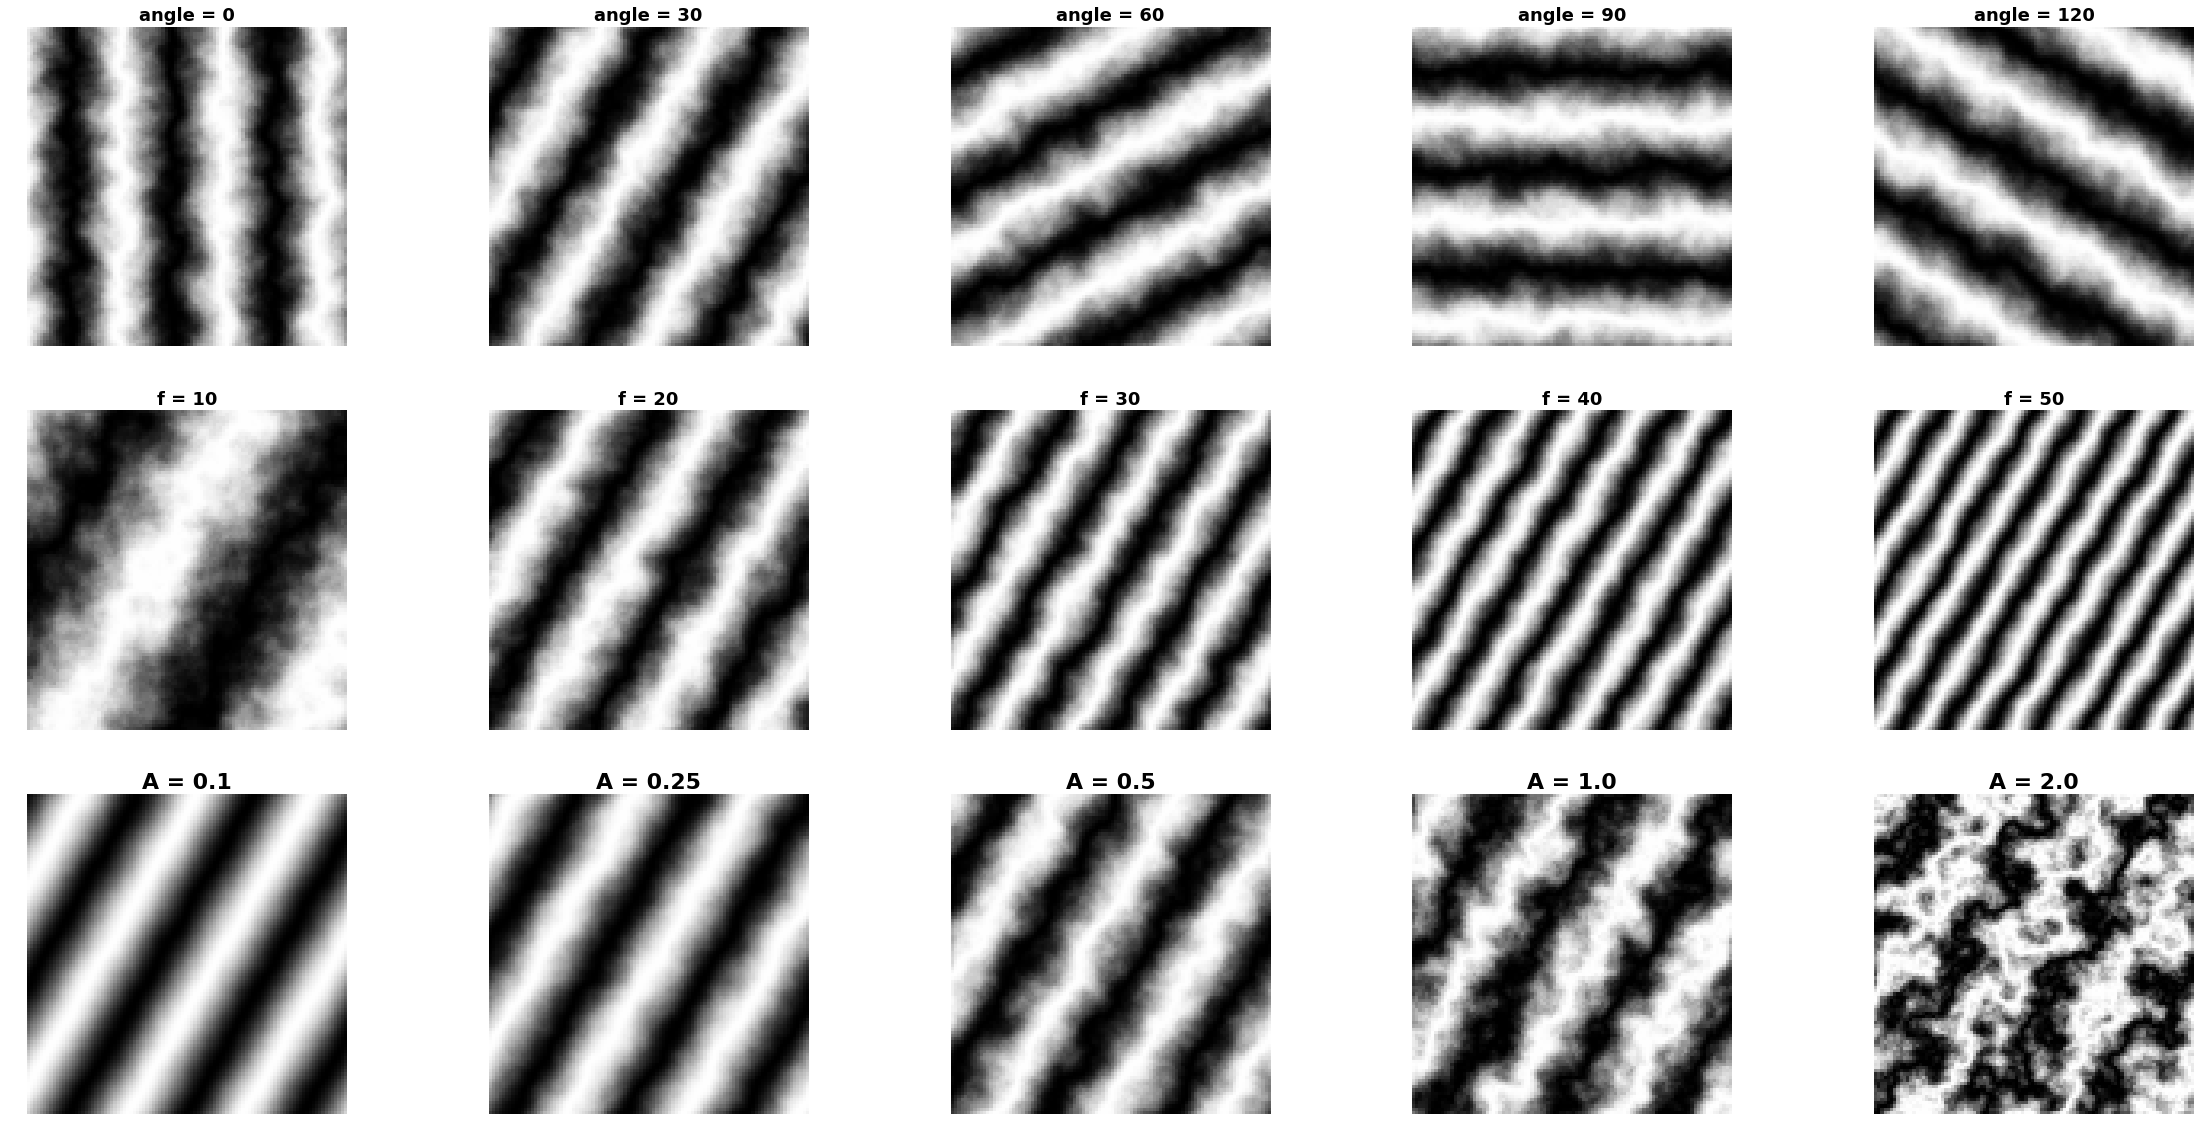

In [11]:
angles = [0, 30, 60, 90, 120]
freqs = [10, 20, 30, 40, 50]
ampls = [0.10, 0.25, 0.5, 1., 2.]

plt.figure(figsize=(40,20))
n=1

# ANGLE VARIATIONS
for j, theta in tqdm(zip(range(5), angles)):
    noise = NoiseUtils(imageSize=100, angle=theta, frequency=20., amplitude=0.5)
    noise.makeTexture(texture=noise.marble)

    plt.subplot(3,5,n)
    plt.imshow(noise.img, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('angle = {}'.format(theta), fontweight='bold', fontsize=18)
    n += 1

# FREQUENCY VARIATIONS
for j, f in tqdm(zip(range(5), freqs)):
    noise = NoiseUtils(imageSize=100, angle=30, frequency=f, amplitude=0.5)
    noise.makeTexture(texture=noise.marble)

    plt.subplot(3,5,n)
    plt.imshow(noise.img, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('f = {}'.format(f), fontweight='bold', fontsize=18)
    n += 1

# AMPLITUDE VARIATIONS
for j, A in tqdm(zip(range(5), ampls)):
    noise = NoiseUtils(imageSize=100, angle=30, frequency=20., amplitude=A)
    noise.makeTexture(texture=noise.marble)

    plt.subplot(3,5,n)
    plt.imshow(noise.img, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('A = {}'.format(A), fontweight='bold', fontsize=22)
    n += 1

plt.show()

### Tests (during development)

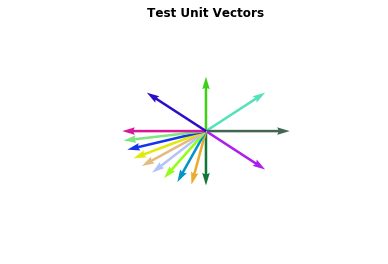

In [7]:
def show_vectors():

    for theta in [0, 45, 90, 135, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 315]:
        v = unit_vector(angle=theta)

        plt.quiver([0], [0], [v[0]], [v[1]], angles='xy', scale_units='xy', scale=1, color=np.random.rand(3,))
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.axis('off')
        plt.title("Test Unit Vectors", fontweight='bold')
    plt.show()
show_vectors()

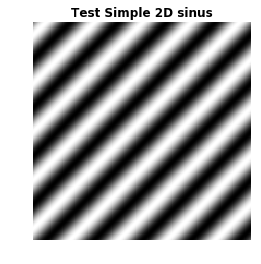

In [31]:
def sine_image(angle=0, freq=1, size=100, perlin=0):
    
    # Creates a 2d grid of coordinates and a vector with the right angle
    U = np.transpose(np.mgrid[0:size,0:size], axes=(1,2,0))
    v = np.expand_dims(unit_vector(angle), axis=1)
    
    # Computes the 2d sine wave that fluctuates in onne direction of given angle
    sin_2d = np.sin(freq * np.squeeze(np.dot(U, v)))
    return sin_2d

def show_image(image):
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title("Test Simple 2D sinus", fontweight='bold')
    plt.show()
    
show_image(sine_image(angle=45, freq=0.2, size=200))